# Exploratory Spatio-Temporal Data Analysis
# Part 1 - Data Inspection and Descriptive Statistics - Summary Statistics

In [1]:
import xarray as xr
import folium

In [2]:
ds = xr.open_dataset('/workspace/soil-ml-modeling-pipeline/ml-modeling-pipeline/data/02_intermediate/preprocessed_power_nasa_data.nc')

In [3]:
ds

<xarray.Dataset> Size: 648B
Dimensions:            (time: 0, lat: 45, lon: 36)
Coordinates:
  * time               (time) datetime64[ns] 0B 
  * lat                (lat) float64 360B -4.5 -4.0 -3.5 -3.0 ... 16.5 17.0 17.5
  * lon                (lon) float64 288B 29.38 30.0 30.62 ... 50.0 50.62 51.25
Data variables: (12/15)
    PRECTOTCORR        (time, lat, lon) float64 0B ...
    EVPTRNS            (time, lat, lon) float64 0B ...
    T2M                (time, lat, lon) float64 0B ...
    TS                 (time, lat, lon) float64 0B ...
    PS                 (time, lat, lon) float64 0B ...
    WS2M               (time, lat, lon) float64 0B ...
    ...                 ...
    GWETROOT           (time, lat, lon) float64 0B ...
    GWETPROF           (time, lat, lon) float64 0B ...
    GWETTOP            (time, lat, lon) float64 0B ...
    PRECIPITATIONCAL   (time, lat, lon) float64 0B ...
    CLOUD_AMT          (time, lat, lon) float64 0B ...
    ALLSKY_SFC_SW_DWN  (time, lat, lon) float64 0B ...

## Data Inspection

### Area of intrest - South Sudan and Ethopia

In [4]:
def plot_dataset_boundaries(ds: xr.Dataset):
    """
    Creates an interactive map visualizing the boundaries of the provided xarray.Dataset based on its latitude and longitude coordinates.

    Parameters:
    - ds (xr.Dataset): The dataset containing the coordinates 'lat' and 'lon'.

    Returns:
    - folium.Map: An interactive map with a rectangle showing the boundaries of the dataset.

    Example:
    >>> ds = xr.open_dataset('path_to_your_dataset.nc')  # Load your dataset
    >>> map_obj = plot_dataset_boundaries(ds)
    >>> map_obj  # This will display the map in a Jupyter Notebook environment
    """

    # Extracting the latitude and longitude data
    try:
        latitudes = ds.coords['lat'].values
        longitudes = ds.coords['lon'].values
    except KeyError as e:
        raise ValueError(f"Missing coordinates in the dataset: {e}")

    # Determining the bounding box for the map
    min_lat, max_lat = latitudes.min(), latitudes.max()
    min_lon, max_lon = longitudes.min(), longitudes.max()

    # Creating a map centered around the center of your bounding box
    map_center = [(min_lat + max_lat) / 2, (min_lon + max_lon) / 2]
    m = folium.Map(location=map_center, zoom_start=6)

    # Adding a rectangle to show the boundary
    folium.Rectangle(
        bounds=[[min_lat, min_lon], [max_lat, max_lon]],
        color='red',
        fill=True,
        fill_opacity=0.2
    ).add_to(m)

    return m

# Example usage 
# plot_dataset_boundaries(ds)

In [5]:
plot_dataset_boundaries(ds)

### Missing values

In [6]:
def count_missing_values(ds, missing_value_indicator=999.0):
    """
    Counts missing values in each data variable within an xarray Dataset.
    Missing values are identified as either NaN or a specified missing value indicator (e.g., 999.0).

    Parameters:
    - ds (xarray.Dataset): The dataset to analyze.
    - missing_value_indicator (float, optional): The numerical value used to indicate missing data.
      Defaults to 999.0.

    Returns:
    - dict: A dictionary where keys are the variable names and values are the counts of missing values.
    """
    missing_values_count = {}
    for var in ds.data_vars:
        # Counting NaN values
        nan_count = ds[var].isnull().sum().item()
        # Counting values equal to the specified missing value indicator
        custom_missing_count = (ds[var] == missing_value_indicator).sum().item()
        # Summing both counts to get the total number of missing values
        total_missing = nan_count + custom_missing_count
        missing_values_count[var] = total_missing
    return missing_values_count

In [7]:
# Assuming 'ds' is your xarray Dataset
missing_values = count_missing_values(ds)

for variable, count in missing_values.items():
    print(f"{variable}: {count} missing values")

PRECTOTCORR: 0 missing values
EVPTRNS: 0 missing values
T2M: 0 missing values
TS: 0 missing values
CLOUD_AMT: 0 missing values
PS: 0 missing values
WS2M: 0 missing values
WS10M: 0 missing values
QV2M: 0 missing values
RH2M: 0 missing values
ALLSKY_SFC_SW_DWN: 0 missing values
GWETROOT: 0 missing values
GWETPROF: 0 missing values
GWETTOP: 0 missing values


## Descriptive statistics

### Summmary statistics


**While preparing to perform summary statistics on the dataset, it's crucial to acknowledge that it covers a vast terrain, including South Sudan and agricultural areas of Ethiopia. This wide geographical spread means we should be cautious about drawing conclusions based solely on these statistics, as they may not fully capture the diverse environmental conditions across different parts of the terrain.**

In [8]:
import xarray as xr
import pandas as pd

def calculate_summary_statistics(dataset):
    summary_stats = []
    for var in dataset.data_vars:
        # Retrieve dimensions present for the current variable
        dims = dataset[var].dims
        
        # Calculate mean, std, min, and max, ignoring NaN values, across all available dimensions
        mean_val = dataset[var].mean(dim=dims, skipna=True)
        std_val = dataset[var].std(dim=dims, skipna=True)
        min_val = dataset[var].min(dim=dims, skipna=True)
        max_val = dataset[var].max(dim=dims, skipna=True)
        
        # Append results as a dictionary to the list
        summary_stats.append({
            'Variable': var,
            'Mean': mean_val.item(),
            'Standard Deviation': std_val.item(),
            'Minimum': min_val.item(),
            'Maximum': max_val.item()
        })
    
    # Convert list of dictionaries to DataFrame
    return pd.DataFrame(summary_stats)

def calculate_annual_summary_statistics(dataset):
    # Group the dataset by year
    grouped = dataset.groupby('timestamp.year')
    
    # List to hold annual stats
    annual_stats = []

    # Iterate over each group (each year)
    for year, year_data in grouped:
        # Use the existing function to calculate stats for this year's data
        stats_df = calculate_summary_statistics(year_data)

        # Add the year to the stats DataFrame
        stats_df['Year'] = year

        # Append the annual stats
        annual_stats.append(stats_df)

    # Concatenate all yearly stats into a single DataFrame
    return pd.concat(annual_stats, ignore_index=True)


In [9]:
# Call the function and store the summary statistics in a DataFrame
stats_df = calculate_summary_statistics(ds)

stats_df

,Variable,Mean,Standard Deviation,Minimum,Maximum
0,PRECTOTCORR,0.000032,0.000069,0.000000,0.004264
1,EVPTRNS,17.674830,24.794361,0.000000,167.804688
2,T2M,295.428766,5.023260,279.023438,313.898438
3,TS,296.747423,5.727158,277.945312,319.820312
4,CLOUD_AMT,52.775386,28.855906,0.000000,99.992188
5,PS,85373.293625,6357.672158,72258.625000,100675.187500
6,WS2M,2.005504,1.002662,0.046875,9.351562
7,WS10M,2.892313,1.258076,0.312500,11.687500
8,QV2M,0.010761,0.002879,0.001160,0.021057
9,RH2M,58.335567,18.055649,6.312500,97.750000


#### *Why 'PRECTOTCORR' is so small?*


The 'PRECTOTCORR' maximum value of 0.014074 is so small because it represents a very low level of average daily precipitation, measured in water mass over the surface of the Earth, even after bias correction. The value of 0.014074 meters (which is 14.074 mm) indicates that on the wettest observed day in the data set, the daily maximum precipitation was low. That day was wetter than a light rain but still not among the heaviest of rains between 2001-2023

In [10]:
# Transpose the DataFrame
stats_df_transposed = stats_df.T

# Set the column names
stats_df_transposed.columns = stats_df_transposed.iloc[0]

# Drop the first row (which was the column names)
stats_df_transposed = stats_df_transposed[1:]

# Reset the index
stats_df_transposed = stats_df_transposed.reset_index(drop=True)

# Convert the data types to float
stats_df_transposed = stats_df_transposed.astype(float)


In [11]:
stats_df_transposed

Variable,PRECTOTCORR,EVPTRNS,T2M,TS,CLOUD_AMT,PS,WS2M,WS10M,QV2M,RH2M,ALLSKY_SFC_SW_DWN,GWETROOT,GWETPROF,GWETTOP
0,0.000032,17.674830,295.428766,296.747423,52.775386,85373.293625,2.005504,2.892313,0.010761,58.335567,246.611312,0.571964,0.575216,0.499276
1,0.000069,24.794361,5.023260,5.727158,28.855906,6357.672158,1.002662,1.258076,0.002879,18.055649,44.082821,0.167994,0.167935,0.239026
2,0.000000,0.000000,279.023438,277.945312,0.000000,72258.625000,0.046875,0.312500,0.001160,6.312500,38.812500,0.203125,0.203125,0.062500
3,0.004264,167.804688,313.898438,319.820312,99.992188,100675.187500,9.351562,11.687500,0.021057,97.750000,350.273438,1.000000,1.000000,1.000000


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_box_plots(df):
    """
    Creates a grid of box plots with annotated statistics for each column in the provided DataFrame.

    Parameters:
    - df (DataFrame): A transposed DataFrame where each column represents a variable to plot.

    The function will display the plots and does not return any value.
    """
    
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")  # 'whitegrid' style adds a grid and improves readability

    # Determine the number of plots to display 
    columns_to_plot = [col for col in df.columns]

    # Calculate the number of rows needed for subplots (e.g., 2 plots per row)
    n_rows = (len(columns_to_plot) + 1) // 2

    # Create a figure and axes with subplots
    fig, axes = plt.subplots(n_rows, 2, figsize=(20, 5 * n_rows))  # Adjust the size as needed
    fig.tight_layout(pad=5.0)  # Add space between plots

    # Flatten the axes array if necessary
    axes = axes.flatten()

    # Create a palette with a distinct color for each plot
    palette = sns.color_palette("husl", len(columns_to_plot))

    # Plot each column in its subplot
    for i, column in enumerate(columns_to_plot):
        # Use the ith subplot and set a color from the palette
        sns.boxplot(data=df[column], width=0.5, ax=axes[i], color=palette[i])
        
        # Annotate the plot with statistics
        stats = df[column].describe()
        annotations_text = (
            f"Min: {stats['min']:.3f}\n"
            f"Mean: {stats['mean']:.3f}\n"
            f"Std: {stats['std']:.3f}\n"
            f"Max: {stats['max']:.3f}"
        )
        axes[i].text(0.95, 0.85, annotations_text, transform=axes[i].transAxes, 
                     verticalalignment='top', horizontalalignment='right', fontsize=12, 
                     bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))  # pad adjusted to 0.4 as requested

        # Set titles and labels with a larger font
        axes[i].set_title(f'Box Plot for {column}', fontsize=16)
        axes[i].set_xlabel(column, fontsize=14)
        axes[i].set_ylabel('Values', fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=12)

    # Hide any unused axes if the number of plots is odd
    if len(columns_to_plot) % 2 != 0:
        axes[-1].set_visible(False)  # Hide the last subplot if there's an odd number of columns

    plt.show()  # Display the combined figure with all

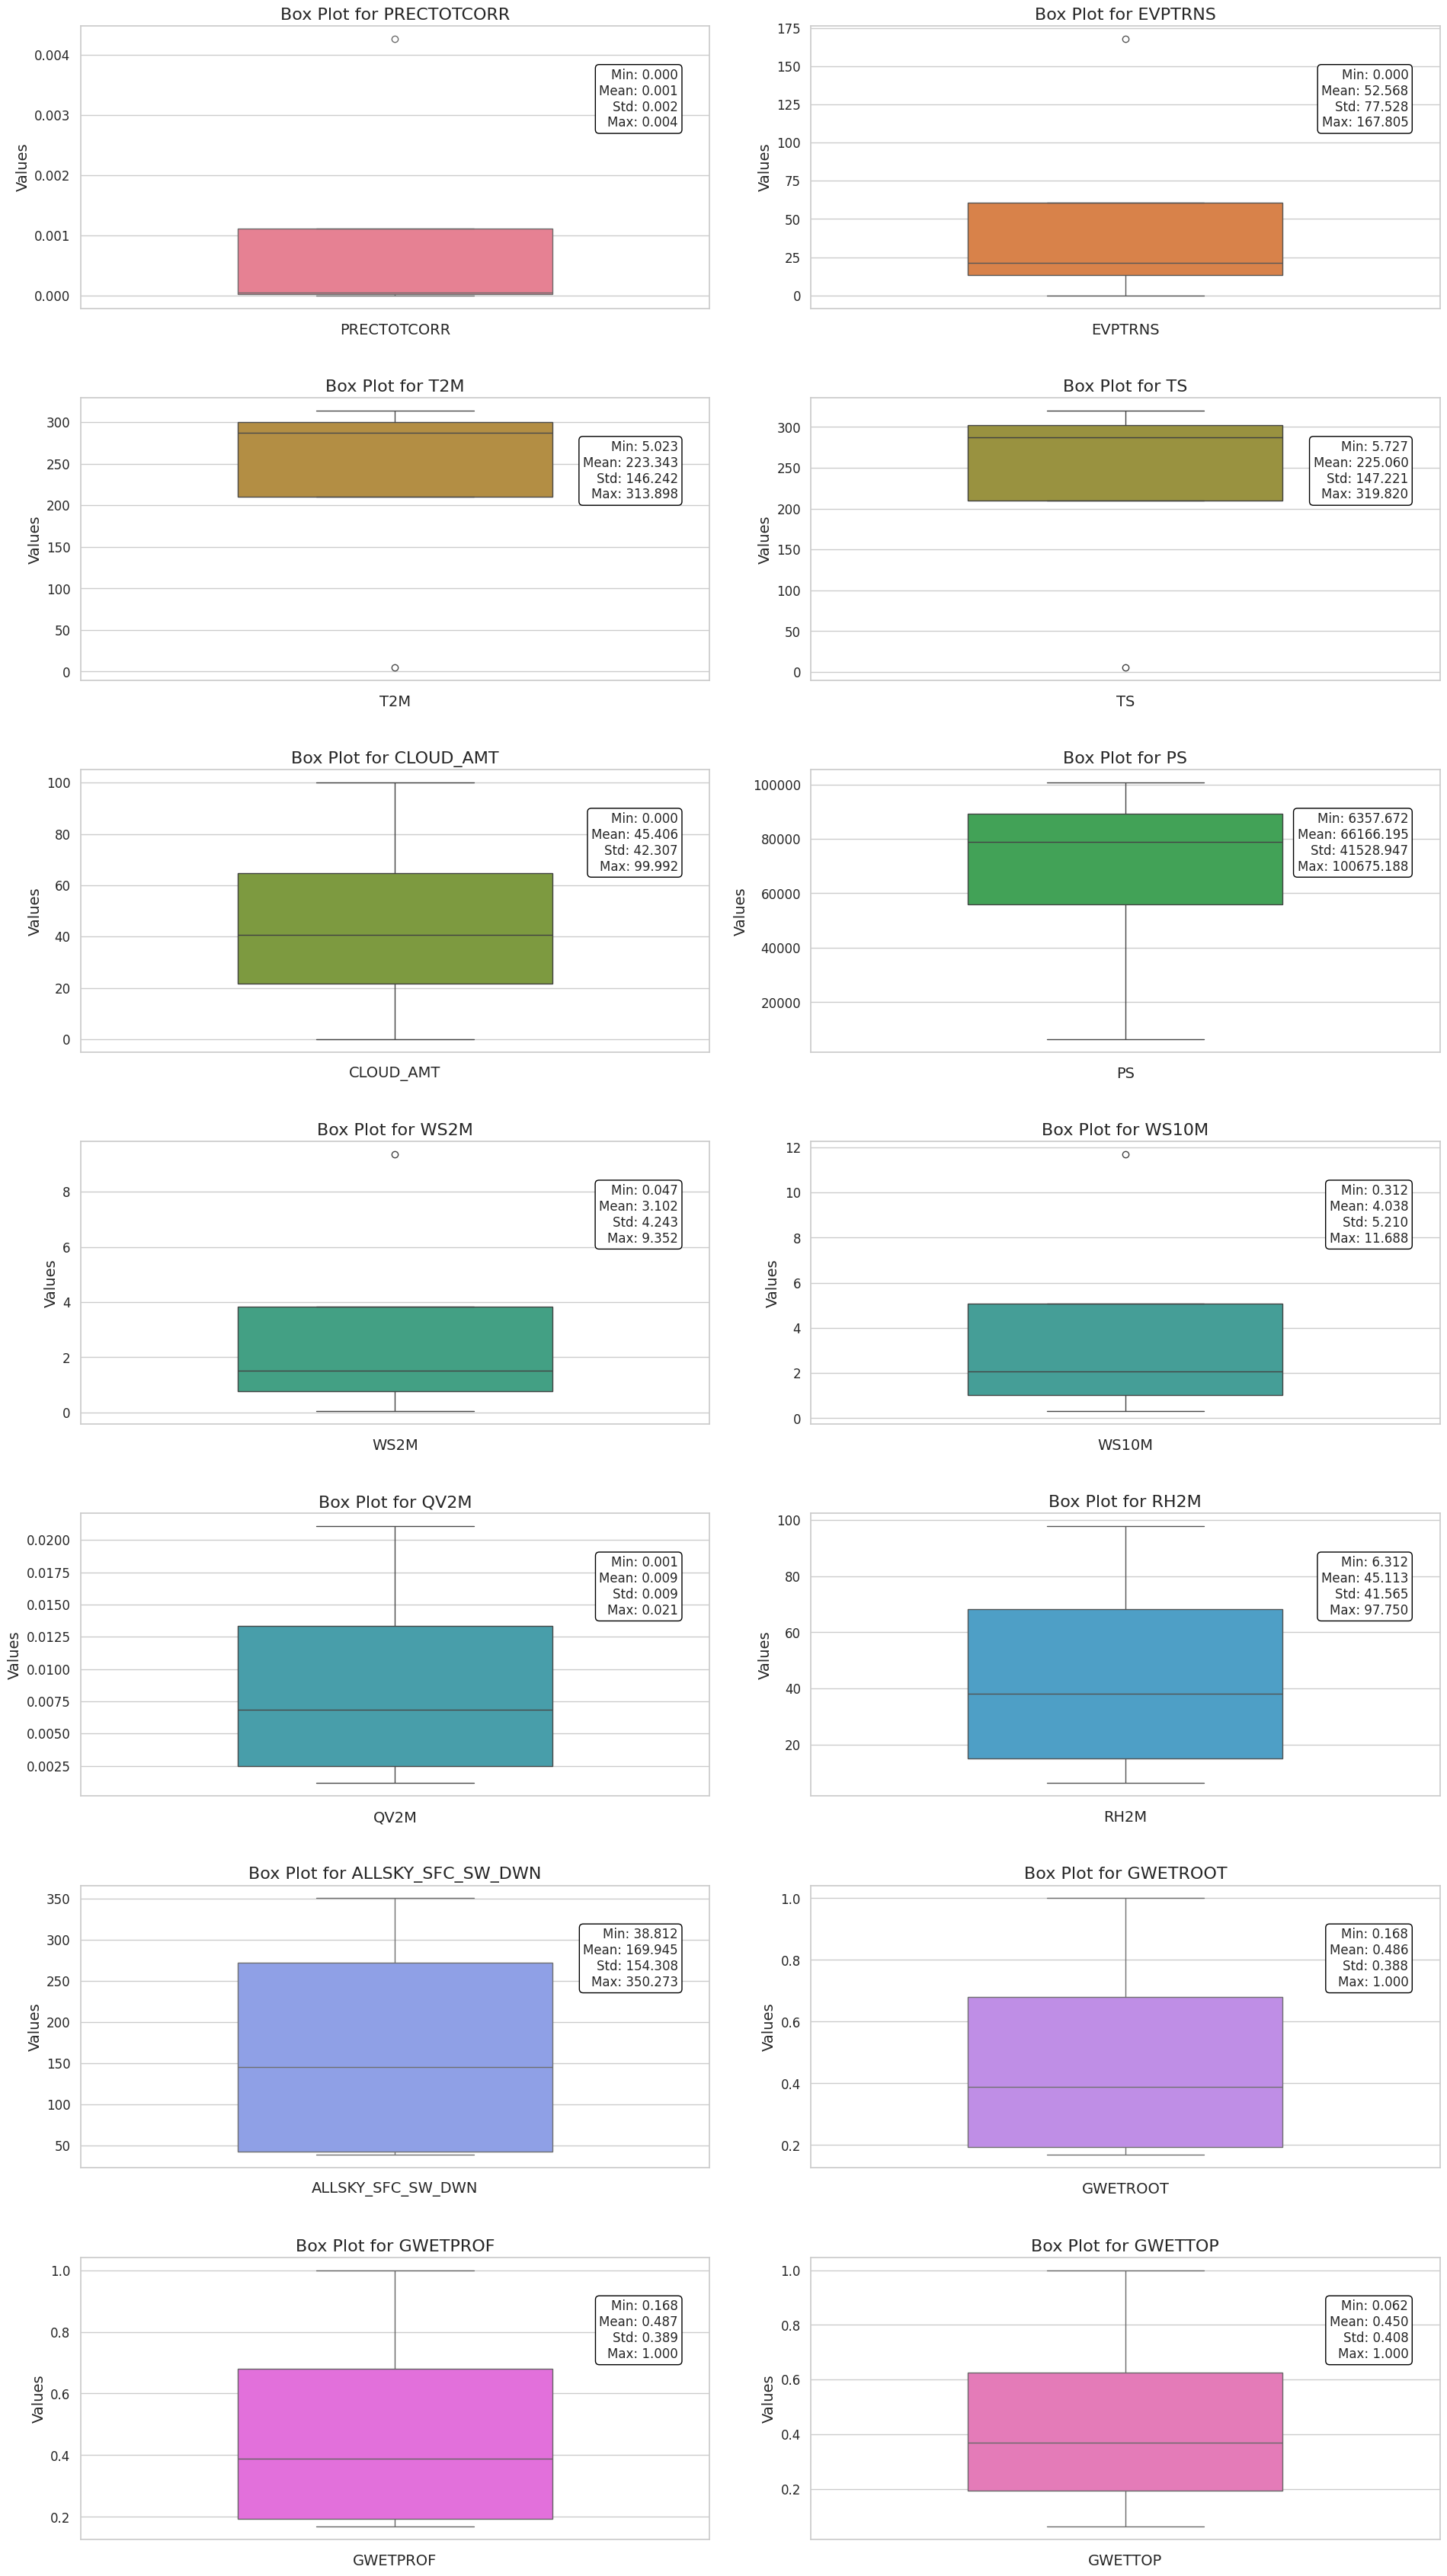

In [13]:
# Example usage with your DataFrame
create_box_plots(stats_df_transposed)

#### Why some have lines within the box plots and some don't?

The absence of a line also known as "whiskers" between the upper quartile and the maximum value (or the lower quartile and the minimum value) suggests that the maximum (or minimum) value lies within the upper (or lower) quartile; in other words, the maximum value is not beyond the range that would typically define an outlier. 

In [14]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

def plot_variable_distributions(dataset, sample_times=10):
    """
    Plots histograms of variables in an xarray.Dataset for randomly sampled timestamps.
    
    Parameters:
    - dataset (xarray.Dataset): The dataset containing the variables.
    - sample_times (int): The number of timestamps to randomly sample for plotting histograms.
    
    This function plots histograms for data variables that include the 'timestamp' dimension,
    after randomly selecting a number of timestamps.
    """
    
    # Filter out the excluded variables
    variables = [var for var in dataset.data_vars]
    
    # Prepare the figure layout
    n_vars = len(variables)
    fig, axes = plt.subplots(n_vars, 1, figsize=(10, 5 * n_vars))  # Only one column of plots now
    
    # Handle case when there is only one variable to plot
    if n_vars == 1:
        axes = [axes]
    
    for i, var in enumerate(variables):
        data_var = dataset[var]
        
        # Check if the 'timestamp' dimension exists for the variable
        if 'timestamp' in data_var.dims:
            random_indices = np.random.choice(dataset.timestamp.size, size=sample_times, replace=False)
            sampled_times = data_var.isel(timestamp=random_indices)
            for time in sampled_times:
                axes[i].hist(time.values.flatten(), bins=30, alpha=0.5)
            # Removed the legend line
            axes[i].set_title(f'Histograms of {var}')
        else:
            axes[i].text(0.5, 0.5, 'No timestamp dimension', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Histograms of {var} (not available)')
    
    plt.tight_layout()
    plt.show()


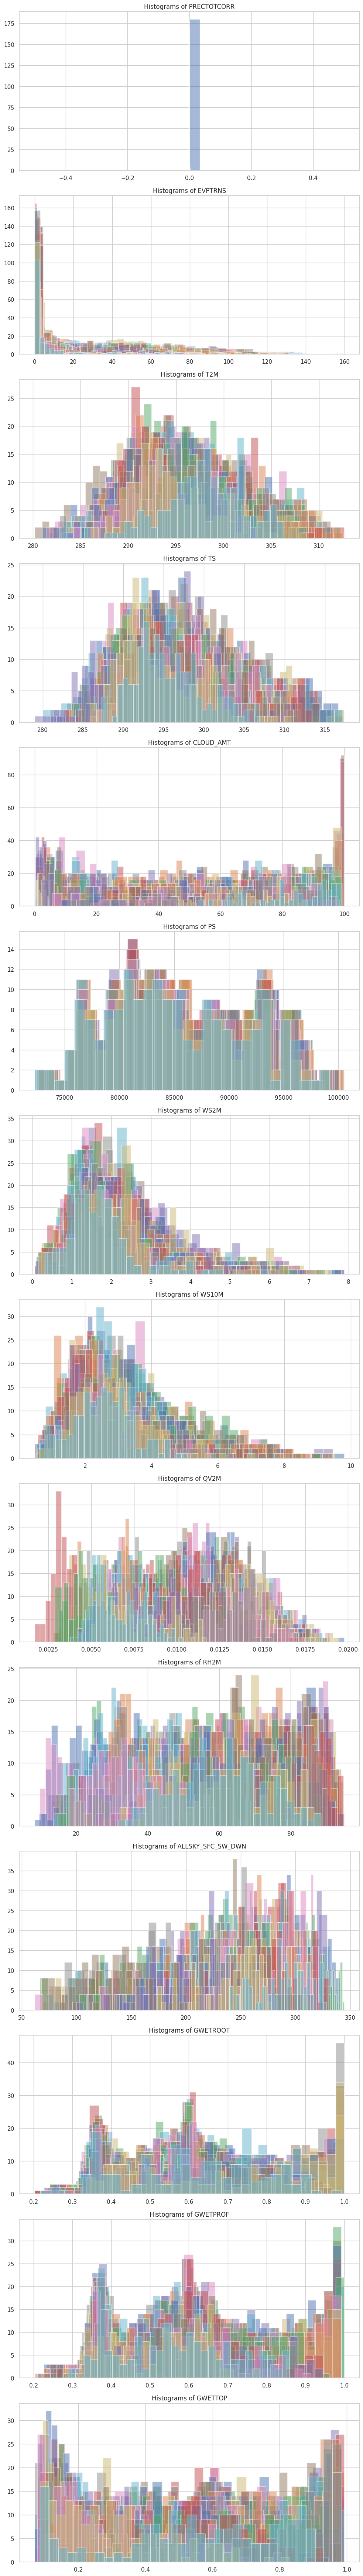

In [15]:
# Usage example:
# Assuming 'ds' is your xarray.Dataset loaded with data
plot_variable_distributions(ds, sample_times=180)

In [16]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

def plot_variable_distributions(dataset, sample_times=100):
    """
    Plots histograms of variables in an xarray.Dataset for randomly sampled timestamps.

    This function is designed to visualize the distribution of each data variable that includes the
    'timestamp' dimension in the dataset. It allows the user to specify how many random timestamps
    to sample for the histograms, enabling a quick visualization of data variability over time.

    Parameters:
    - dataset (xarray.Dataset): The dataset containing the variables to plot.
    - sample_times (int): The number of random timestamps to sample from the dataset.

    The histograms help in understanding the distribution and potential anomalies or patterns in the dataset,
    which can be critical for further data analysis or modeling steps.
    """
    
    # Filter out the excluded variables and prepare plots
    variables = [var for var in dataset.data_vars]
    n_vars = len(variables)
    fig, axes = plt.subplots(n_vars, 1, figsize=(10, 5 * n_vars))  # Adjusted layout for clarity
    
    # Handle single variable case
    if n_vars == 1:
        axes = [axes]
    
    # Iterate through variables to plot histograms
    for i, var in enumerate(variables):
        data_var = dataset[var]
        # Only plot if 'timestamp' is a dimension
        if 'timestamp' in data_var.dims:
            random_indices = np.random.choice(dataset.timestamp.size, size=sample_times, replace=False)
            sampled_data = data_var.isel(timestamp=random_indices)
            axes[i].hist(sampled_data.values.flatten(), bins=30, alpha=0.5, label=f'Timestamps sampled')
            axes[i].set_title(f'Histogram of {var}')
            axes[i].legend()
        else:
            axes[i].text(0.5, 0.5, 'No timestamp dimension', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Variable {var} does not have a timestamp dimension')
    
    plt.tight_layout()
    plt.show()


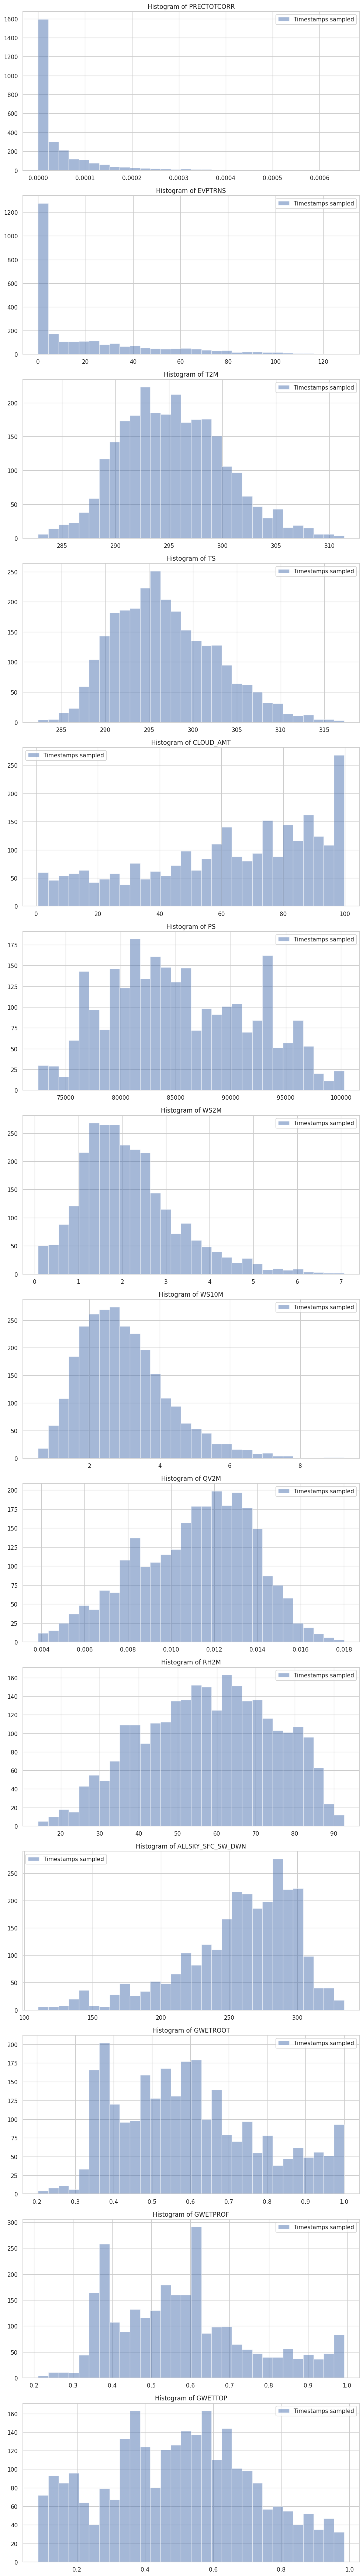

In [17]:
# Example Usage:
# dataset = xr.open_dataset('path_to_your_netcdf_file.nc')
plot_variable_distributions(ds, sample_times=15)